In [1]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from dyt import DYT
from rmsnorm import TritonRMSNorm

In [2]:
dtype = torch.bfloat16
device = 'cuda'
bs, seq_len, dim = 1, 2048, 9192
x1 = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
x1.requires_grad_(True)
x2 = deepcopy(x1)
dyt1 = DYT(dim).to(device).to(dtype)
dyt1.gemma.data.copy_(torch.randn(dim))
dyt1.beta.data.copy_(torch.randn(dim))
dyt2 = deepcopy(dyt1)


In [3]:
y1 = dyt1(x1, "torch")
y2 = dyt2(x2, "triton")
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print((dyt1.gemma.grad-dyt2.gemma.grad).abs().max(), (dyt1.gemma.grad-dyt2.gemma.grad).abs().mean())
print((dyt1.beta.grad-dyt2.beta.grad).abs().max(), (dyt1.beta.grad-dyt2.beta.grad).abs().mean())
print((dyt1.alpha.grad-dyt2.alpha.grad).abs() / dyt1.alpha.grad.abs())


tensor(0.0312, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0006, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor(0.0312, device='cuda:0', dtype=torch.bfloat16) tensor(0.0005, device='cuda:0', dtype=torch.bfloat16)
tensor(0.5000, device='cuda:0', dtype=torch.bfloat16) tensor(0.0354, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor([0.0056], device='cuda:0', dtype=torch.bfloat16)


bs: 8, seq_len: 1024


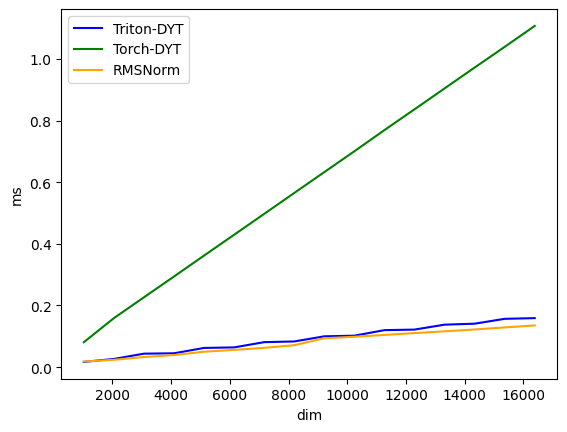

forward:
        dim  Triton-DYT  Torch-DYT   RMSNorm
0    1024.0    0.016871   0.080814  0.018228
1    2048.0    0.026542   0.158903  0.023852
2    3072.0    0.043668   0.226462  0.032854
3    4096.0    0.044879   0.293982  0.039062
4    5120.0    0.062241   0.361871  0.050085
5    6144.0    0.063990   0.429414  0.055889
6    7168.0    0.081023   0.497142  0.062609
7    8192.0    0.083251   0.564922  0.071160
8    9216.0    0.099912   0.632631  0.093575
9   10240.0    0.102025   0.700219  0.098538
10  11264.0    0.119964   0.768925  0.104472
11  12288.0    0.121743   0.836302  0.110394
12  13312.0    0.137742   0.904095  0.116131
13  14336.0    0.140873   0.971771  0.122113
14  15360.0    0.156689   1.038909  0.128811
15  16384.0    0.158915   1.106846  0.135136


In [7]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'triton'))
    if provider == 'Torch-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'torch'))
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: norm(tensor))
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 8, seq_len: 1024


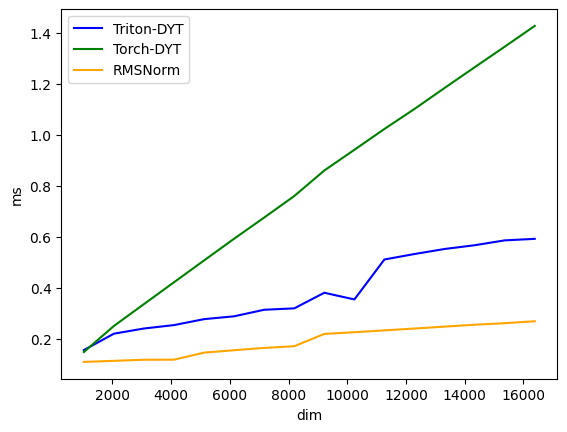

backward:
        dim  Triton-DYT  Torch-DYT   RMSNorm
0    1024.0    0.156620   0.148946  0.110257
1    2048.0    0.221003   0.251206  0.114513
2    3072.0    0.241341   0.337017  0.118777
3    4096.0    0.254703   0.422681  0.119083
4    5120.0    0.278027   0.508300  0.146690
5    6144.0    0.289179   0.593459  0.156157
6    7168.0    0.314847   0.676536  0.165267
7    8192.0    0.320327   0.760819  0.171809
8    9216.0    0.381534   0.861077  0.220181
9   10240.0    0.355322   0.942193  0.226701
10  11264.0    0.512093   1.024012  0.234056
11  12288.0    0.533459   1.102449  0.241130
12  13312.0    0.553174   1.184647  0.248756
13  14336.0    0.567927   1.265919  0.256124
14  15360.0    0.586962   1.346569  0.262197
15  16384.0    0.593023   1.428105  0.269828


In [6]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    dy = torch.rand_like(tensor)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        y = dyt(tensor, 'triton')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Torch-DYT':
        dyt = DYT(dim).to(device).to(dtype)
        y = dyt(tensor, 'torch')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        y = norm(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
